In [1]:
# install.packages("verification")
# install.packages("data.table")
# install.packages("ggplot2")
#install.packages("stringr")

In [1]:
library(verification)
library(data.table)
library(ggplot2)
library(stringr)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

Loading required package: boot

Loading required package: CircStats

Loading required package: MASS

Loading required package: dtw

Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:spam’:

    as.matrix


The following objects are masked from ‘package:stats’:


In [2]:
dt = fread("data/eval/test.csv")

In [3]:
res_crps = crps(dt$glc_dt[dt$msk==0],cbind(dt$mu[dt$msk==0],dt$sig[dt$msk==0]))
res_crps$CRPS
res_crps$IGN

[1] 0.1303857

[1] -0.03875065

In [29]:
res_crps = crps(dt$glc_dt[dt$msk==0 & exp(dt$glc_dt + log(140)) > 80 & exp(dt$glc_dt + log(140)) < 200],
                cbind(dt$mu[dt$msk==0 & exp(dt$glc_dt + log(140)) > 80 & exp(dt$glc_dt + log(140)) < 200],
                      dt$sig[dt$msk==0 & exp(dt$glc_dt + log(140)) > 80 & exp(dt$glc_dt + log(140)) < 200]))
res_crps$CRPS
res_crps$IGN

[1] 0.1036369

[1] -0.2545512

In [4]:
crps_df = data.frame(glc_dt = exp(dt$glc_dt[dt$msk==0] + log(140)),crps = res_crps$crps,ign = res_crps$ign)
dim(crps_df)

[1] 71414     3

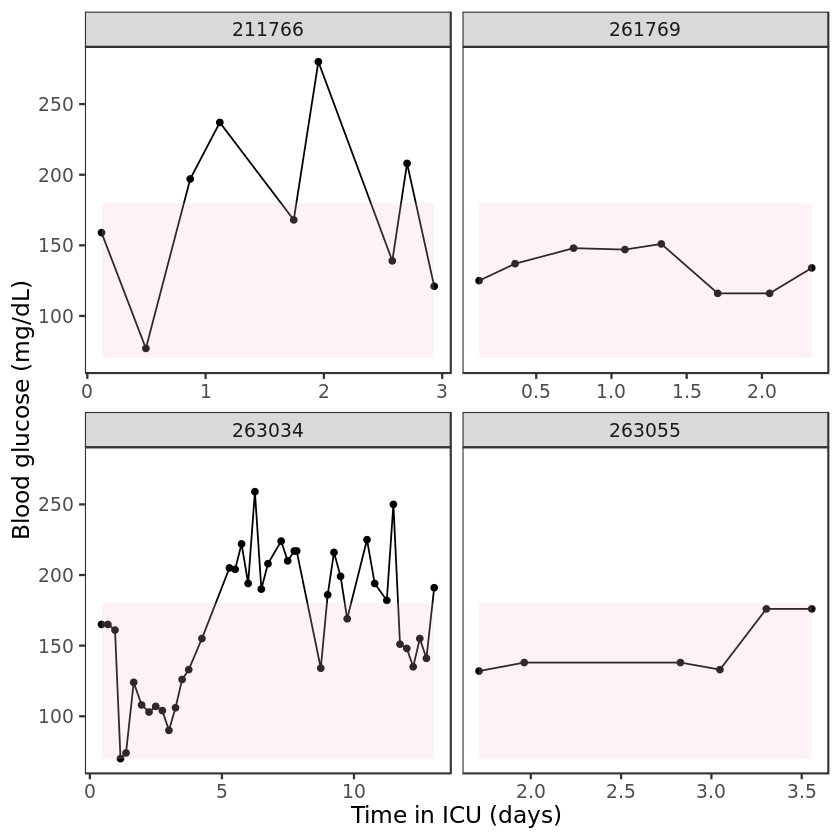

In [77]:
set.seed(1234)
samp4 = sample(unique(dt$icustay_id),4)
ggplot(dt[icustay_id %in% samp4],aes(x=timer/24,y=exp(glc+log(140)))) +
geom_point() +
geom_line() +
facet_wrap(~icustay_id,scales="free_x") +
theme_bw(base_size=14) +
geom_ribbon(aes(ymax=180,ymin=70),fill="pink",alpha=0.2) +
labs(x="Time in ICU (days)",y="Blood glucose (mg/dL)") +
theme(panel.grid=element_blank())
ggsave("experiments/samp4.png",width=6,height=4)

In [102]:
set.seed(1234)
samp2 = sample(dt[,.(min=min(timer),max=max(timer),.N),by=icustay_id][N > 10 & N < 12 & min < 6 & max < 48]$icustay_id,4)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



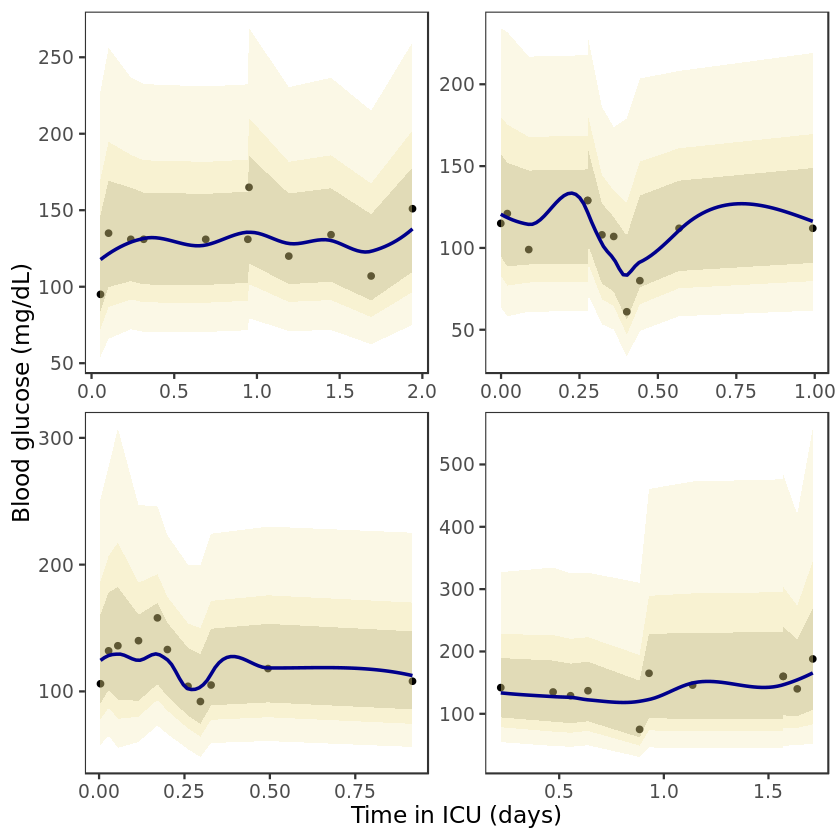

In [123]:
ggplot(dt[icustay_id %in% samp2],aes(x=timer/24,y=exp(glc+log(140)))) +
geom_point(aes(y=exp(glc+log(140)))) +
facet_wrap(~icustay_id,ncol=2,scale="free") +
theme_bw(base_size=14) +
geom_ribbon(aes(ymax=exp(upper99+log(140)),ymin=exp(lower99+log(140))),fill="lightgoldenrod",alpha=0.2) +
geom_ribbon(aes(ymax=exp(upper95+log(140)),ymin=exp(lower95+log(140))),fill="lightgoldenrod2",alpha=0.2) +
geom_ribbon(aes(ymax=exp(upper80+log(140)),ymin=exp(lower80+log(140))),fill="lightgoldenrod4",alpha=0.2) +
geom_smooth(aes(y=exp(mu+log(140))),col="darkblue",se=FALSE,span=0.6) +
labs(x="Time in ICU (days)",y="Blood glucose (mg/dL)") +
theme(panel.grid=element_blank(),strip.background = element_blank(),strip.text.x = element_blank())
ggsave("experiments/samp4_predictions.png",width=6,height=4)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
`geom_smooth()` using method = 'gam' and formula

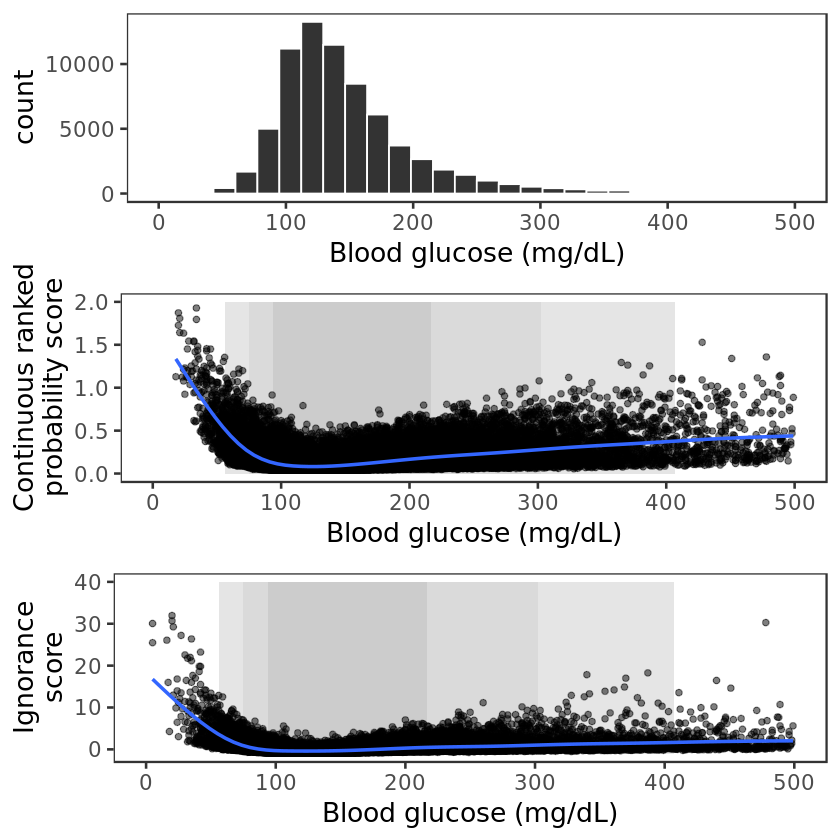

In [6]:
qvals = quantile(crps_df$glc_dt,c(0.005,0.995))
qvals0 = quantile(crps_df$glc_dt,c(0.025,0.975))
qvals1 = quantile(crps_df$glc_dt,c(0.1,0.9))

p1 = ggplot(crps_df,aes(x=glc_dt)) + 
geom_histogram(fill="gray20",color="white") +
labs(x="Blood glucose (mg/dL)") +
theme_bw(base_size=16) +
theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank()) +
scale_x_continuous(limits=c(0,500))

p2 = ggplot(crps_df,aes(x=glc_dt,y=crps)) + 
geom_rect(aes(xmin=qvals[1],xmax=qvals[2],ymin=0,ymax=2),fill="gray90",alpha=0.8) +
geom_rect(aes(xmin=qvals0[1],xmax=qvals0[2],ymin=0,ymax=2),fill="gray85",alpha=0.8) +
geom_rect(aes(xmin=qvals1[1],xmax=qvals1[2],ymin=0,ymax=2),fill="gray80",alpha=0.8) +
geom_point(alpha=0.5) +
geom_smooth() +
labs(x="Blood glucose (mg/dL)",y="Continuous ranked\nprobability score") +
theme_bw(base_size=16) +
theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank()) +
scale_y_continuous(limits=c(0,2)) +  # removes 8 measures
scale_x_continuous(limits=c(0,500))

p3 = ggplot(crps_df,aes(x=glc_dt,y=ign)) +
geom_rect(aes(xmin=qvals[1],xmax=qvals[2],ymin=-1,ymax=40),fill="gray90",alpha=0.8) +
geom_rect(aes(xmin=qvals0[1],xmax=qvals0[2],ymin=-1,ymax=40),fill="gray85",alpha=0.8) +
geom_rect(aes(xmin=qvals1[1],xmax=qvals1[2],ymin=-1,ymax=40),fill="gray80",alpha=0.8) +
geom_point(alpha=0.5) +
geom_smooth() +
labs(x="Blood glucose (mg/dL)",y="Ignorance\nscore") +
theme_bw(base_size=16) +
theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank()) +
scale_y_continuous(limits=c(-1,40)) +  # removes 2 measures
scale_x_continuous(limits=c(0,500))

gridExtra::grid.arrange(p1,p2,p3,ncol=1)
p_out = gridExtra::arrangeGrob(p1,p2,p3,ncol=1)
ggsave(plot=p_out,filename="experiments/mimic/graphs/crps_ign.png")

In [7]:
# verify(obs=dt$glc_dt[dt$msk==0],pred=cbind(dt$mu[dt$msk==0],dt$sig[dt$msk==0]),frcst.type="norm.dist",obs.type="cont")

In [8]:
res95 = dt[msk==0,.(incl = as.numeric(glc_dt > lower95 & glc_dt < upper95),glc_dt,dt = timer_dt - timer)]
res95 = res95[dt < 13]

In [9]:
res95[,dtc := cut(dt,10)]

In [10]:
res95[,t0 := as.numeric(str_extract(dtc, "[0-9]+"))]

In [11]:
res95sum = res95[,.(c95 = mean(incl),.N),by=t0]
res95sum

t0,c95,N
<dbl>,<dbl>,<int>
3,0.9343536,7449
5,0.9487541,16333
6,0.9317238,3852
1,0.9505372,9401
7,0.9166667,1200
2,0.9308103,4307
0,0.9659235,21305
11,0.9464964,2897
10,0.9218147,1036


In [12]:
res95sum[,c95upper := c95 + 2*sqrt(c95*(1-c95)/N)]
res95sum[,c95lower := c95 - 2*sqrt(c95*(1-c95)/N)]

In [13]:
res95sum

t0,c95,N,c95upper,c95lower
<dbl>,<dbl>,<int>,<dbl>,<dbl>
3,0.9343536,7449,0.9400927,0.9286145
5,0.9487541,16333,0.9522047,0.9453034
6,0.9317238,3852,0.9398514,0.9235961
1,0.9505372,9401,0.9550098,0.9460645
7,0.9166667,1200,0.9326238,0.9007095
2,0.9308103,4307,0.9385441,0.9230765
0,0.9659235,21305,0.9684094,0.9634376
11,0.9464964,2897,0.9548583,0.9381344
10,0.9218147,1036,0.9384962,0.9051332


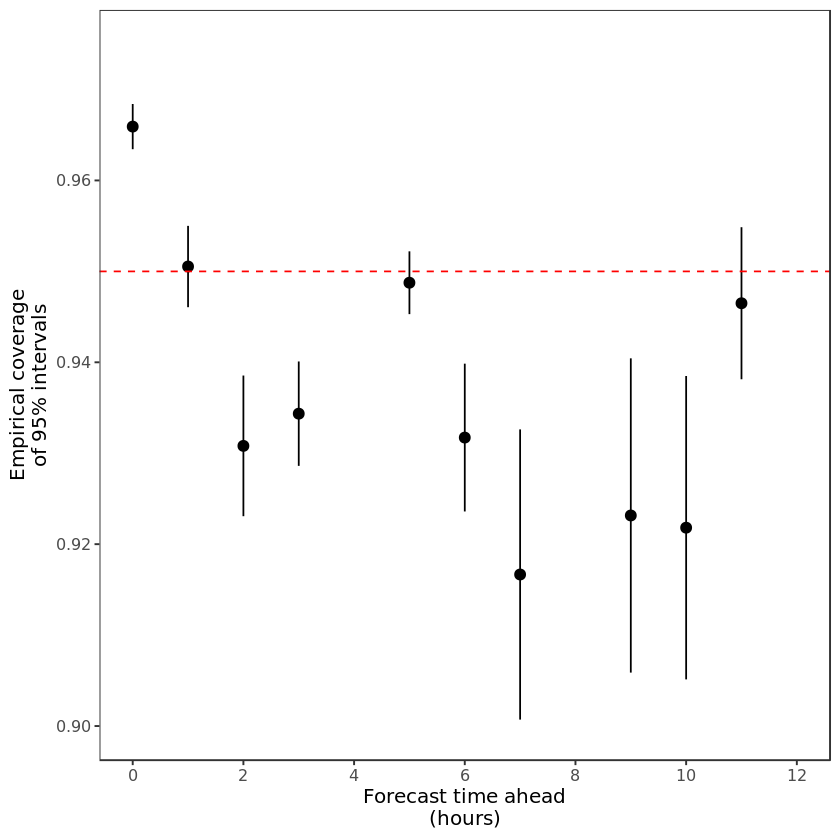

In [112]:
ggplot(res95sum,aes(x=t0,y=c95)) +
geom_point()+
geom_pointrange(aes(ymax=c95upper,ymin=c95lower))+
coord_cartesian(xlim=c(0,12),ylim=c(0.9,0.975)) +
geom_hline(yintercept=0.95,col="red",linetype=2) +
theme_bw(base_size=12)+
theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank())  +
scale_x_continuous(breaks=seq(0,12,2)) +
labs(x="Forecast time ahead\n(hours)",y="Empirical coverage\nof 95% intervals")
ggsave(filename="experiments/mimic/graphs/coverage95.png",height=4,width=4)

In [20]:
head(res95)

incl,glc_dt,dt,dtc,t0
<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,0.6113172,3.97,"(3.9,5.2]",3
1,0.9664405,6.12,"(5.2,6.5]",5
1,0.8724881,4.43,"(3.9,5.2]",3
1,0.7213181,7.65,"(6.5,7.8]",6
1,-0.7519877,2.37,"(1.3,2.6]",1
1,-0.4090429,8.18,"(7.8,9.1]",7


In [18]:
dt[,any_insulin := input_short_injection>0 | input_short_push>0 | input_short_injection>0 | input_short_injection>0]

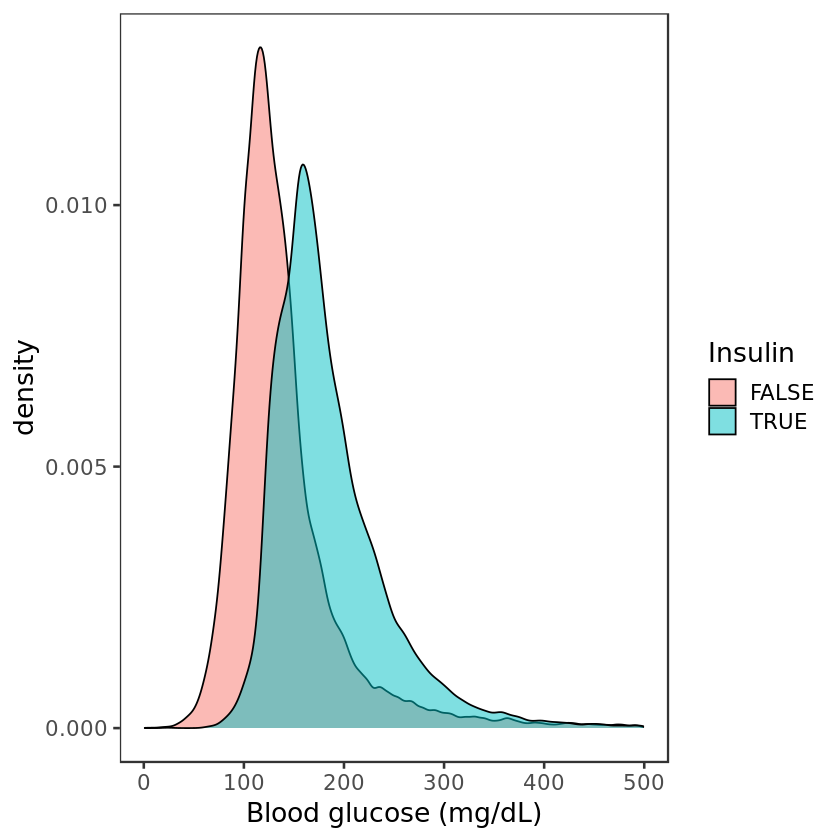

In [166]:
ggplot(dt,aes(x=exp(glc+log(140)),fill=any_insulin)) +
geom_density(alpha=0.5) +
theme_bw(base_size=16) +
labs(x="Blood glucose (mg/dL)") +
theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank())  +
scale_fill_discrete(name="Insulin")
ggsave(filename="experiments/mimic/graphs/treated_insulin_overlap.png",height=5,width=8)

In [34]:
names(dt)

[1] "subject_id"                      "hadm_id"                        
  [3] "icustay_id"                      "icu_admissiontime"              
  [5] "icu_dischargetime"               "timer"                          
  [7] "timer_dt"                        "glc"                            
  [9] "glc_dt"                          "msk"                            
 [11] "input_short_injection"           "input_short_push"               
 [13] "input_intermediate"              "input_long"                     
 [15] "starttime"                       "endtime"                        
 [17] "input_hrs"                       "infxstop"                       
 [19] "demo_admission_age"              "demo_weight_first"              
 [21] "demo_height_first"               "demo_diabetes_uncomplicated"    
 [23] "demo_diabetes_complicated"       "elix_congestive_heart_failure"  
 [25] "elix_cardiac_arrhythmias"        "elix_valvular_disease"          
 [27] "elix_pulmonary_circulation"      "elix_peripheral_vascular"       
 [29] "elix_hypertension"               "elix_paralysis"                 
 [31] "elix_other_neurological"         "elix_chronic_pulmonary"         
 [33] "elix_hypothyroidism"             "elix_renal_failure"             
 [35] "elix_liver_disease"              "elix_peptic_ulcer"              
 [37] "elix_aids"                       "elix_lymphoma"                  
 [39] "elix_metastatic_cancer"          "elix_solid_tumor"               
 [41] "elix_rheumatoid_arthritis"       "elix_coagulopathy"              
 [43] "elix_obesity"                    "elix_weight_loss"               
 [45] "elix_fluid_electrolyte"          "elix_blood_loss_anemia"         
 [47] "elix_deficiency_anemias"         "elix_alcohol_abuse"             
 [49] "elix_drug_abuse"                 "elix_psychoses"                 
 [51] "elix_depression"                 "vital_heartrate"                
 [53] "vital_sysbp"                     "vital_dbp"                      
 [55] "vital_meanbp"                    "vital_resprate"                 
 [57] "vital_tmpc"                      "vital_spo2"                     
 [59] "ventilated"                      "med_dopamine_rate"              
 [61] "med_dobutamine_rate"             "med_milirinone_rate"            
 [63] "med_phenylephrine_rate"          "med_epinephrine_rate"           
 [65] "med_norepinephrine_rate"         "fluid_rate_all"                 
 [67] "fluid_rate_in"                   "fluid_rate_out"                 
 [69] "lab_aniongap"                    "lab_albumin"                    
 [71] "lab_bands"                       "lab_bicarbonate"                
 [73] "lab_bilirubin"                   "lab_creatinine"                 
 [75] "lab_chloride"                    "lab_hematocrit"                 
 [77] "lab_hemoglobin"                  "lab_lactate"                    
 [79] "lab_platelet"                    "lab_potassium"                  
 [81] "lab_ptt"                         "lab_inr"                        
 [83] "lab_pt"                          "lab_sodium"                     
 [85] "lab_bun"                         "lab_wbc"                        
 [87] "dialysis_present"                "dialysis_active"                
 [89] "demo_gender_F"                   "demo_gender_M"                  
 [91] "demo_ethnicity_grouped_asian"    "demo_ethnicity_grouped_black"   
 [93] "demo_ethnicity_grouped_hispanic" "demo_ethnicity_grouped_native"  
 [95] "demo_ethnicity_grouped_other"    "demo_ethnicity_grouped_unknown" 
 [97] "demo_ethnicity_grouped_white"    "dt"                             
 [99] "mu"                              "sig"                            
[101] "lower80"                         "upper80"                        
[103] "lower95"                         "upper95"                        
[105] "lower99"                         "upper99"                        
[107] "glc_dt_locf"                     "probs"                          
[109] 

In [31]:
inject_dt = dt[input_short_injection > 0 ]

In [32]:
inject_dt[,dt := timer_dt-timer]
inject_dt[,change := exp(mu +log(140))-exp(glc+log(140))]
inject_dt[,true_change := exp(glc_dt +log(140))-exp(glc+log(140))]

In [33]:
inject_dt[,input_short_injection_bin := cut(input_short_injection,5)]

In [34]:
table(inject_dt$input_short_injection_bin)


(0.775,0.82] (0.82,0.865] (0.865,0.91] (0.91,0.955]    (0.955,1] 
        6389         1093         4266         3229         3681 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



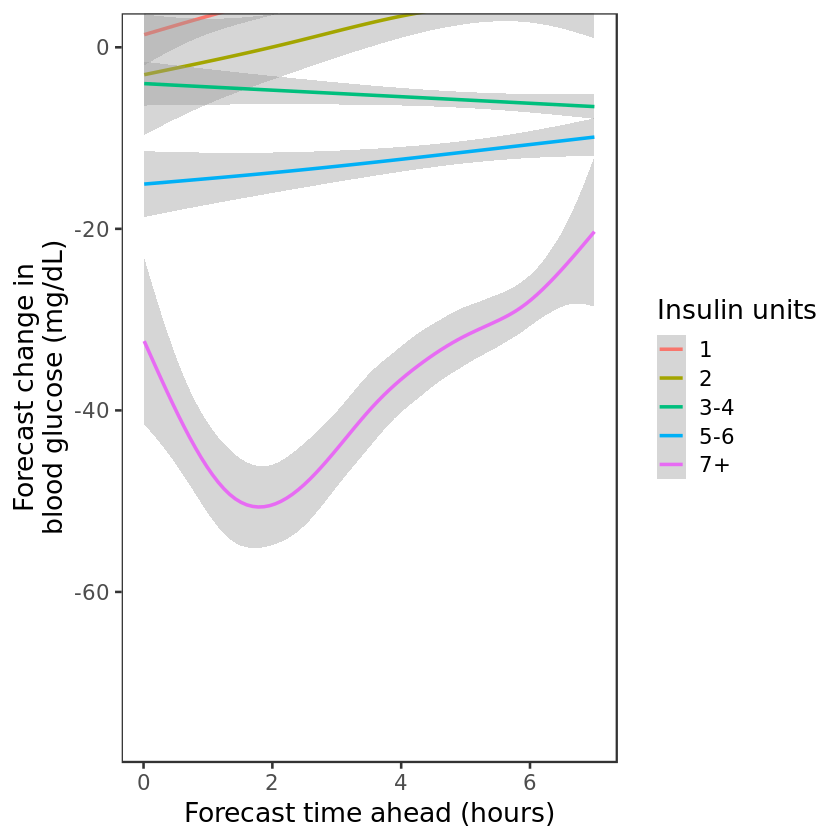

In [51]:
ggplot(inject_dt[dt < 7 & msk == 0],aes(x=dt,y=change+17)) +
#geom_point(alpha=0.2) +
geom_smooth(aes(col=input_short_injection_bin)) +
theme_bw(base_size=16) +
theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank())  +
coord_cartesian(ylim=c(-75,0)) +
scale_color_discrete(name="Insulin units",labels=c('1','2','3-4','5-6','7+')) +
labs(x="Forecast time ahead (hours)",y="Forecast change in\nblood glucose (mg/dL)")
ggsave(filename="experiments/mimic/graphs/insulin_effect.png",height=3,width=8)

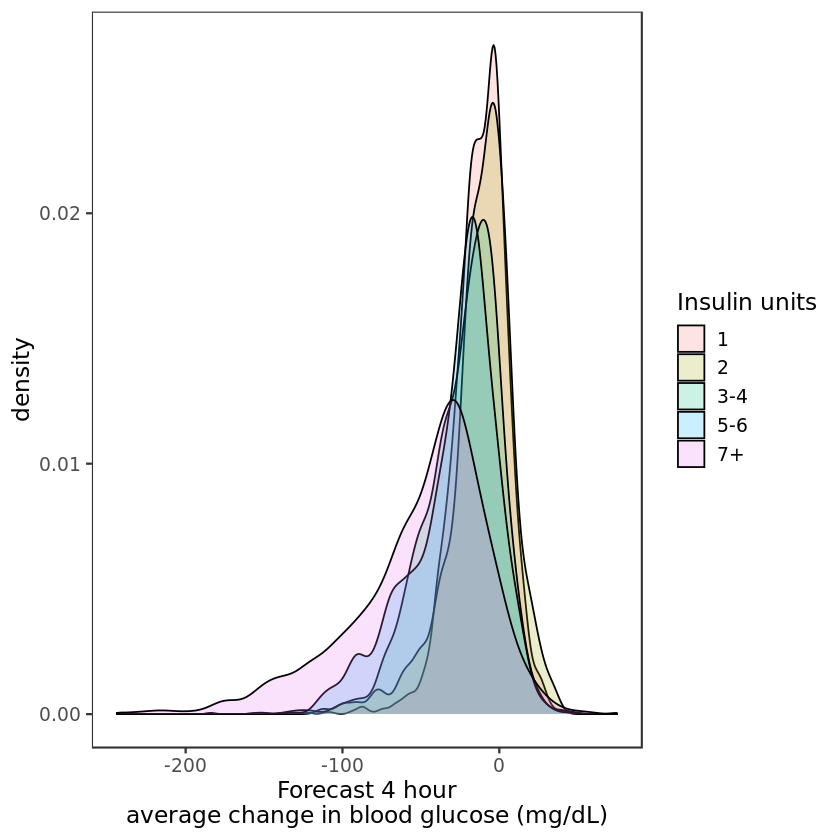

In [74]:
ggplot(inject_dt[dt < 6 & dt > 3 & msk == 0],
           aes(x=change,fill = input_short_injection_bin)) +
geom_density(alpha=0.2) +
scale_fill_discrete(name="Insulin units",labels=c('1','2','3-4','5-6','7+')) +
theme_bw(base_size=14) +
theme(panel.grid=element_blank()) +
labs(x="Forecast 4 hour\naverage change in blood glucose (mg/dL)")
ggsave(filename="experiments/mimic/graphs/insulin_effect_4h.png",height=3,width=8)

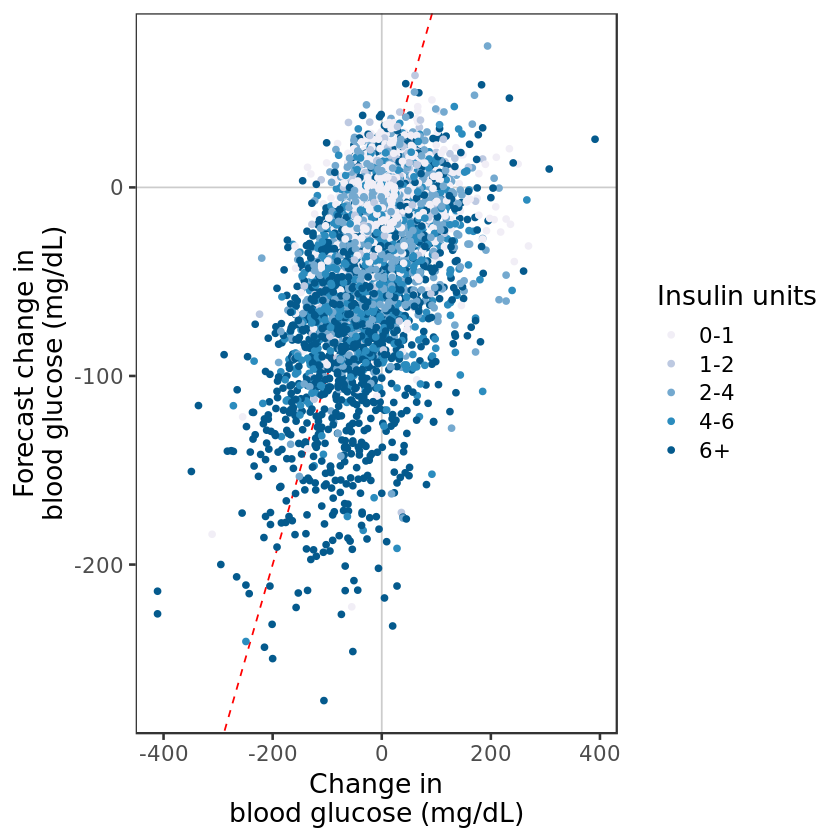

In [164]:
ggplot(inject_dt[dt < 6 & msk == 0],aes(y=change,x=true_change,col=input_short_injection_bin)) +
geom_abline(slope = 1,intercept=0,col="red",linetype=2) +
geom_hline(yintercept = 0,col="gray80") +
geom_vline(xintercept = 0,col="gray80") +
geom_point() +
theme_bw(base_size=16) +
labs(x="Change in\nblood glucose (mg/dL)",y="Forecast change in\nblood glucose (mg/dL)") +
theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank())  +
scale_color_brewer(name="Insulin units",labels=c('0-1','1-2','2-4','4-6','6+'),palette = 9) 
ggsave(filename="experiments/mimic/graphs/forecast_actual_plot.png",height=5,width=8)

In [102]:
dt[,dt := timer_dt-timer]
dt[,change := exp(mu +log(140))-exp(glc+log(140))]
dt[,true_change := exp(glc_dt +log(140))-exp(glc+log(140))]

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



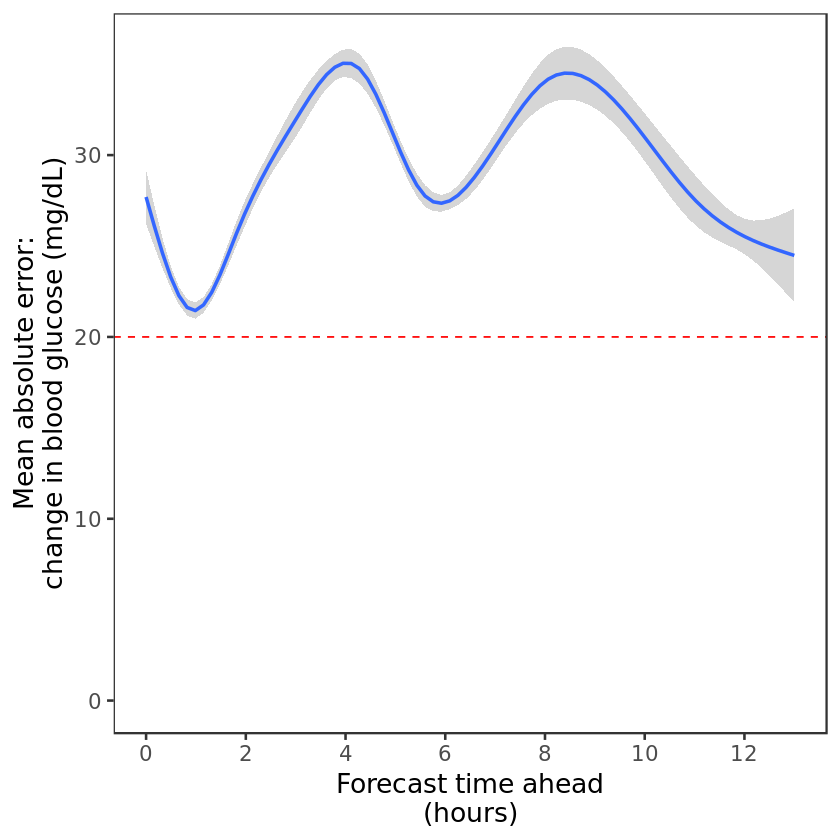

In [162]:
ggplot(dt[msk==0 & dt < 13],aes(x=dt,y=abs(true_change-change))) +
geom_smooth()+
#geom_point(alpha=0.1) +
theme_bw(base_size=16) +
theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank())  +
labs(x = "Forecast time ahead\n(hours)",y="Mean absolute error:\nchange in blood glucose (mg/dL)") +
coord_cartesian(ylim=c(0,36)) +
geom_hline(yintercept = 20,col="red",linetype=2) +
scale_x_continuous(breaks=seq(0,12,2))
#theme(legend.position="none")+
ggsave(filename="experiments/mimic/graphs/mae_time_plot.png",height=5,width=8)

In [130]:
dt1 = fread("data/test.csv")

In [131]:
inject_dt1 = dt1[input_short_injection > 0]

In [132]:
quantile(inject_dt1$input_short_injection)

0%  25%  50%  75% 100% 
   1    2    4    6   23